This notebook demonstrates how to use inferred groups to implement the multiple thresholds per group as used by the original paper on equalized odds

Equality of opportunity in supervised learning

Hardt et al.

and the more recent follow-up work

Unprocessing Seven Years of Algorithmic Fairness

Cruz and Hardt

We will compare these results using inferred attributes with fairlearn.

In [1]:
import oxonfair as fair
from oxonfair import group_metrics as gm
import xgboost
import numpy as np

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will load the adult dataset, train XGBoost on it, and a fair baseline method using one threshold per group.

For direct comparison with Cruz and Hardt, and fairlearn, we use the L_infinity version of equalized odds given by `gm.equalized_odds_max` -- corresponding to the maximum violation, rather than more stable average violation provided by `gm.equalized_odds`.

In [2]:
train,val,test = fair.dataset_loader.adult(train_proportion=0.4,test_proportion=0.3)
classifier = xgboost.XGBClassifier().fit(train['data'],train['target'])
fpred = fair.FairPredictor(classifier,val).fit(gm.accuracy,gm.equalized_odds_max,0.01)

We now define 3 variants of thresholding. 

1. `random_group_fn` randomly assigns one of two thresholds to each member of a particular group as in Hardt et al., and Cruz and Hardt.
2. `groups_fn` is a deterministic version of the same.
3. `inferred_group_fun` is a modified version of 2. that works when group labels are not available at test time by using a second classifier to infer group membership.

In [3]:
def random_group_fn(data):
    return data['sex']*2 + (np.random.randn(data.shape[0])>0)

def groups_fn(data):
    return data['sex']*2 + classifier.predict(data)

def inferred_group_fun(data):
    return group_class.predict(data)*2 + classifier.predict(data)

Now we generate a comparison of the different strategies (baseline OxonFair, random_groups and deterministic).

We find that deterministic and random strategies are largely interchangeable, and baseline performs much worse.

Substantially fewer groups (2) used in true groups than in the infered groups (4)
Substantially fewer groups (2) used in true groups than in the infered groups (4)


Text(0.5, 1.0, 'A comparision of randomized and deterministic Eq. Odds Strategies')

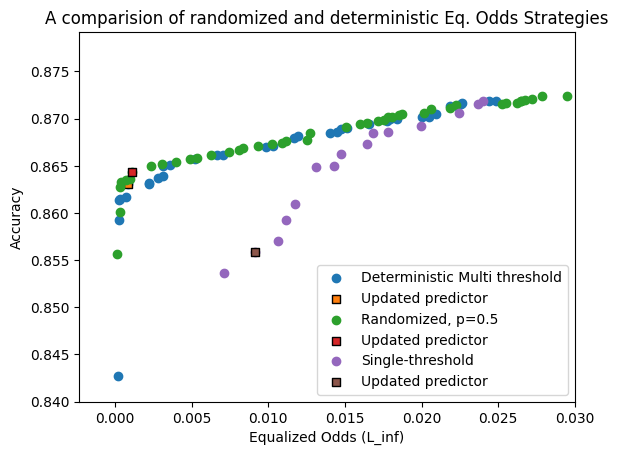

In [4]:
from matplotlib import pyplot as plt
fpred2 = fair.FairPredictor(classifier,val,inferred_groups=groups_fn,threshold=0).fit(gm.accuracy,gm.equalized_odds_max,0.002)
fpred3 = fair.FairPredictor(classifier,val,inferred_groups=random_group_fn,threshold=0).fit(gm.accuracy,gm.equalized_odds_max,0.002)
fpred2.plot_frontier(name_frontier='Deterministic Multi threshold',show_original=False)
fpred3.plot_frontier(name_frontier='Randomized, p=0.5',new_plot=False,show_original=False)
fpred.plot_frontier(name_frontier='Single-threshold',show_original=False,new_plot=False)

plt.ylim(bottom=0.84)
plt.xlim(right=0.03)
plt.title('A comparision of randomized and deterministic Eq. Odds Strategies')
#plt.savefig('Eo_comp.pdf')

Plot the same on test.

There is too much noise to see anything.

(-0.002630489483929168, 0.03)

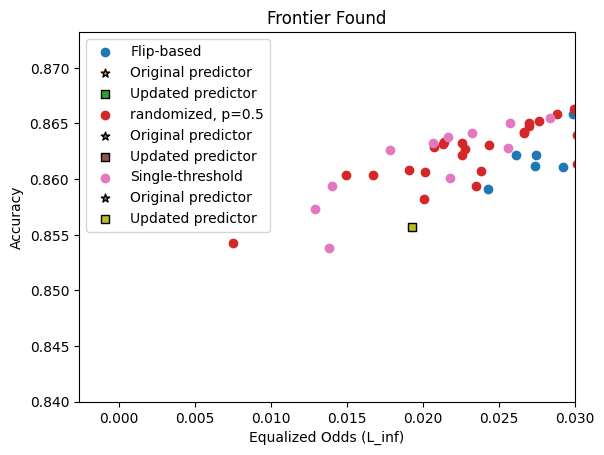

In [5]:
fpred2.plot_frontier(test,name_frontier='Flip-based')
fpred3.plot_frontier(test,name_frontier='randomized, p=0.5',new_plot=False)
fpred.plot_frontier(test,name_frontier='Single-threshold',new_plot=False)
plt.ylim(bottom=0.84)
plt.xlim(right=0.03)

To better understand the trade-offs when enforcing equalized odds we plot the per group sensitivity and specificity, and how equalized odds alters these.

While equalized odds can decrease both sensitivity and specificity for the best performing class, it doesn't have to, and you may need to rerun the entire notebook multiple times until you see this behaviour.

(0.3, 0.9)

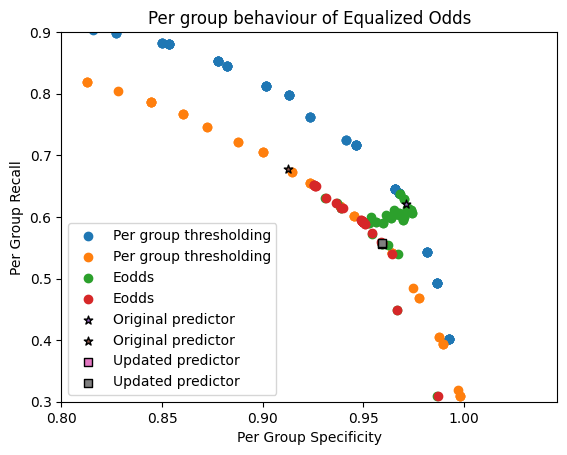

In [6]:
fpred.fit(gm.recall,gm.specificity)
fpred.plot_frontier(objective1=gm.recall.per_group,objective2=gm.specificity.per_group,show_original=False,show_updated=False,name_frontier='Per group thresholding')
fpred2.plot_frontier(objective1=gm.recall.per_group,objective2=gm.specificity.per_group, new_plot=False,name_frontier='Eodds')
plt.title('Per group behaviour of Equalized Odds')
plt.xlim(left=0.8)
plt.ylim(bottom=0.3,top=0.9)
#plt.savefig('per_group_eodds.pdf')

We now consider the same task but with inferred groups. We reload adult, but discarding the groups and train a baseline method using single thresholds and the new multi-threshold approach.

In [7]:
train,val,test = fair.dataset_loader.adult(train_proportion=0.4,test_proportion=0.3,discard_groups=True)
classifier = xgboost.XGBClassifier().fit(train['data'],train['target'])
group_class = xgboost.XGBClassifier().fit(train['data'],train['groups']==' Female')
fpred_inf = fair.FairPredictor(classifier,val,inferred_groups=inferred_group_fun,threshold=0).fit(gm.accuracy,gm.equalized_odds_max,0.02)
fpred_inf_base = fair.FairPredictor(classifier,val,inferred_groups=group_class).fit(gm.accuracy,gm.equalized_odds_max,0.02)

Substantially fewer groups (2) used in true groups than in the infered groups (4)


We plot on validation data.

Text(0.5, 1.0, 'Eodds with inferred groups (Validation)')

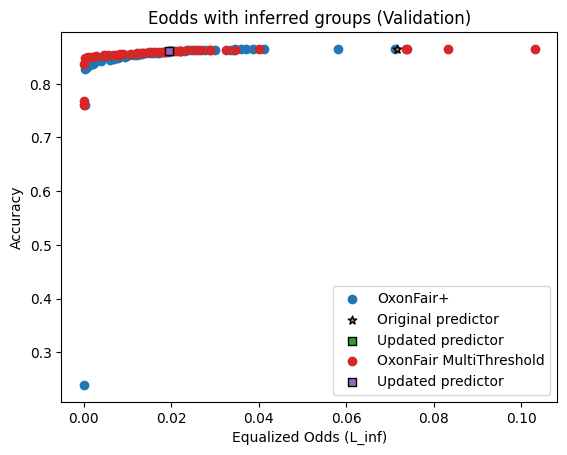

In [8]:
fpred_inf_base.plot_frontier(new_plot=False,name_frontier='OxonFair+')
fpred_inf.plot_frontier(new_plot=False, show_original=False,name_frontier='OxonFair MultiThreshold')
plt.title('Eodds with inferred groups (Validation)')
#plt.savefig('eodd_val.pdf')

Now we compare against fairlearn when enforcing equalized odds.

In [9]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
mitagator = ExponentiatedGradient(xgboost.XGBClassifier(), EqualizedOdds())
mitagator.fit(X=train['data'],y=train['target'],sensitive_features=train['groups']==' Female')

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/opt/miniconda3/envs/ag/lib/python3.10/site-packages/fai

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x32ee43b80>,
                      estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, g...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...),
                      nu=0.0010112214200075562)

In [10]:
import pandas as pd
fl=fair.performance.evaluate_fairness(test['target'],mitagator.predict(test['data']),test['groups'], metrics={'a':gm.accuracy, 'b':gm.equalized_odds_max})


Now we generate a table of results.

In [11]:
results = pd.concat((fpred_inf.evaluate_fairness(test,metrics={'a':gm.accuracy, 'b':gm.equalized_odds_max})['original'],
                     fpred_inf.evaluate_fairness(test,metrics={'a':gm.accuracy, 'b':gm.equalized_odds_max})['updated'],
           fpred_inf_base.evaluate_fairness(test,metrics={'a':gm.accuracy, 'b':gm.equalized_odds_max})['updated'],
           fl),axis=1,keys=['Original','OxonFair Multi','OxonFair +','FairLearn'])
results

,Original,OxonFair Multi,OxonFair +,FairLearn
Accuracy,0.875725,0.872381,0.870811,0.873132
Equalized Odds (L_inf),0.089202,0.024707,0.024292,0.041808


And plot a comparison on test data.

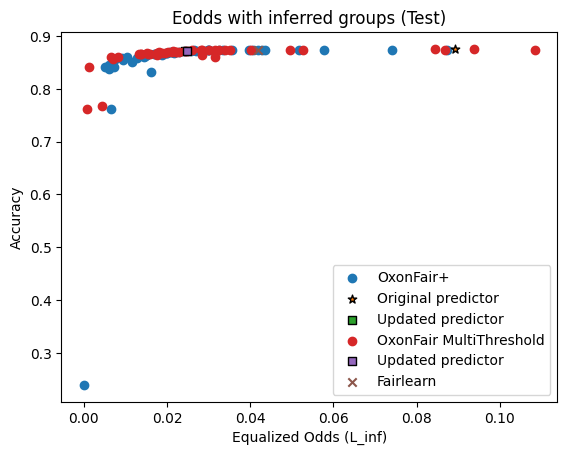

In [12]:
fpred_inf_base.plot_frontier(test,name_frontier='OxonFair+')
fpred_inf.plot_frontier(test,name_frontier='OxonFair MultiThreshold',new_plot=False, show_original=False,)
plt.title('Eodds with inferred groups (Test)')
plt.scatter(fl['Equalized Odds (L_inf)'],fl['Accuracy'], label='Fairlearn',marker='x')
plt.legend()
#plt.savefig('eodd_test.pdf')